WIP: WORK IN PROGRESS! This is not quite working yet.

# Adversarial Autoencoders
Based on impressions on 
[Adversarial Autoencoders](http://arxiv.org/abs/1511.05644) by Alireza Makhzani, Jonathon Shlens, Navdeep Jaitly, Ian Goodfellow. 

If you like this text, please consider submitting typo fixes and grammar corrections so others can better appreciate it.

# On regularization
If I ask you to give me two numbers that sum up to 2, as a normal person, you'd probably choose 1776 and -1774 between the infinitely many couples out there. But if I **restrict both numbers to be** in $\mathbb{N}$ than we had to fall back to 1 and 1. This idea inspired by the Occam's Razor of restricting solutions to the simplest ones is what we call regularization.

We saw regularization before in calculus classes when we studied constrained optimization and lagrance multipliers. We also saw regularization examples when optimizing neural networks for deep learning, where we assumed the weights of the network to be Gaussian random variables and searched for the solution with minimum variance (I'm talking about l2-norm regularization, ridge regression, between many other names). 

The examples above are pointwise or vector regularization cases. In more complex examples, when have to regularize a family of points, in other words, we have to regularize an entire function.

# Functional regularization and Variational Autoencoders
Now that you have proven your ability to sum, I challenge you to give me 1000 numbers that sum up to zero and their squares sum up to one. As a smart person you will simply run `np.random.randn(1000)` and call it close enough. In other words, inside your mind instead of defining the numbers one by one you searched a function $f$ (a probability distribution to be more specific), **forced that function to be zero mean and unity variance** and draw samples from it. The field that deals with optimizing or searching for the best functions that minimizes another function is called Calculus of Variations or Variational Calculus.

I've heard of variational calculus before, but I only started caring about it when I read [Variational AutoEncoders](http://arxiv.org/abs/1312.6114) (VAE), in retrospect I should have studied it earlier, but its OK! VAE's idea is similar to what we did above, instead of optimizing an autoencoder (whose main cost function is the reconstruction error) by imposing pointwise regularization (ex. sparse autoencoders), VAE impose a regularization in the encoder function. VAE regularizes the search for the minimum reconstruction error **restricting the encoder output** to be a zero mean and unity variance Gaussian. It would take forever to test all the possible inputs and regularize the outputs using pointwise methods, this is why we force the entire function at once. (Are you imagining the search in the PDF's space too? Where each function is a point? Trippy isn't it?)

Note, although, that there is no philosophical difference from our Occam's Razor interpretation from above. There are lots of encoders that can successfully calculate codes that are easy to decode. It's like summing two numbers, but to force the solution to be simple, we restrict it to be easy to interpret and manipulate. In probabilities, Gaussians are like 1+1.

The intersection of variational calculus in the space of probability density functions and machine learning is being extensively studied by our lab, [CNEL](http://cnel.ufl.edu/). That intersection is called [Information Theoretic Learning](http://www.cnel.ufl.edu/itl/index.php/Information_Theoretic_Learning).

It is worth, though, asking how can we regularize encoders to other distributions?

# Beyond Gaussians and the adversarial trick
The VAE regularizes the encoder to be a Gaussian by adding to the cost function a Kullback-Liebler divergence term between the encoder's output and a zero mean unity variance Gaussian. It happens that the KL-divergence between two Gaussians is easy to calculate. Variational calculus functionals are all about integrals and sometimes integrals are tricky and intractable. Ask the MCMC guys why they are all excited about VAE and scalable Bayesian inference if you want to see how hard their integrals can be.

On the other hand, if you already read my (broken) [Generative Adversarial Networks](https://github.com/EderSantana/seya/blob/master/examples/wip-GAN.ipynb) notebook you know that we can optimize functionals by playing a min-max game where one function $\mathcal{G}$ tries to generate samples from a dataset and the other function $\mathcal{D}$ tries to tell fake from legit samples. Here we can use the *adversarial trick* to force the encoder function to be as close as possible to a desired distribution and use a discriminator to tell it apart from the real distribution. In that case the encoder will play the role of $\mathcal{G}$.

#####TODO: add schematic diagram

Here are the main differences, in the VAE case, need to define a functional that is based on the KL-divergence between two distributions and calculate its derivative. In the adversarial case, we need to be able to sample from the real distribution we are trying to match and adapt a separate function $\matchcal{D}$. In the space of hyperparameters tested by Makhzani et. al. Adversarial Autoencoders worked better than VAE.

# Code

Cool! Keras time! We will use the same architecture from the Adversarial Autoencoder paper.

We will use [Agnez](https://github.com/AgnezIO/agnez.git) and sklearn to create the visualizations.

In [38]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

from theano import function

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import generic_utils
from keras.optimizers import SGD

from agnez import grid2d, embedding2d, embedding2dplot

batch_size = 100
nb_epoch = 10
code_size = 50

# input image dimensions
img_chan, img_rows, img_cols = 1, 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 9
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows* img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows* img_cols)
X_train = X_train.astype("float32") - 128
X_test = X_test.astype("float32") - 128
X_train /= 128
X_test /= 128

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_valid = X_train[50000:]
Y_valid = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

X_train shape: (60000, 784)
60000 train samples
10000 test samples


In [39]:
# Encoder, also adversarial generator G
enc = Sequential()
enc.add(Dense(1000, input_dim=784))
enc.add(Activation('relu'))
enc.add(Dense(1000))
enc.add(Activation('relu'))
enc.add(Dense(code_size))
enc.add(Activation('tanh'))

# compile encoder
X = K.placeholder(ndim=2)
encoder = K.function([X], [enc(X)])

In [40]:
dec = Sequential()
dec.add(Dense(1000, input_dim=code_size))
dec.add(Activation('relu'))
dec.add(Dense(1000))
dec.add(Activation('relu'))
dec.add(Dense(784))
dec.add(Activation('tanh'))

# compile decoder
X = K.placeholder(ndim=2)
decoder = K.function([X], [dec(X)])

In [41]:
# Autoencoder
ae = Sequential()
ae.add(enc)
ae.add(dec)

sgd1 = SGD(lr=0.01, momentum=0.9)
ae.compile(loss='mse', optimizer=sgd1)

### Note
We have to use two instances of the discriminators $\mathcal{D}$, one on top of the generator/encoder to find fake samples and another that will get the ligit samples as input. For the generator/encoder on the bottom we have two cases again, on that optimizes the encoder to fool D and another that optimizes D to catch the fake samples.

In [42]:
# Adversarial discriminator D
# Base model
D = Sequential()
D.add(Dense(1000, input_dim=code_size))
D.add(Activation('relu'))
D.add(Dense(1000))
D.add(Activation('relu'))
D.add(Dense(1))
D.add(Activation('sigmoid'))

# On top of the generator
D.trainable = False
enc.trainable = True
fake_adapt_enc = Sequential()
fake_adapt_enc.add(enc)
fake_adapt_enc.add(D)

sgd2 = SGD(lr=0.1, momentum=0.0)
fake_adapt_enc.compile(loss='binary_crossentropy', optimizer=sgd2)

# --------------------
D.trainable = True
enc.trainable = False
fake_adapt_D = Sequential()
fake_adapt_D.add(enc)
fake_adapt_D.add(D)

fake_adapt_D.compile(loss='binary_crossentropy', optimizer=sgd2)

# Legit inputs
legit = Sequential()
D.trainable = True
legit.add(D)

legit.compile(loss='binary_crossentropy', optimizer=sgd2)

# Training
Adversarial Autoencoders training takes two turns: 
    1. Reconstruction: where we train the encoder and the decoder to minimize reconstruction error
    2. Regularization: where we train discriminator and encoder to play the functional optimization game.
    
Here we will regularize the encoder to be a $Student-t(df=1)$. Thus you can think about this implementation as a scalable adversarial autoencoder counterpart to the t-SNE method. I'll write a formal paper with comparisons and such later, but you can use and modify this code already.

In [43]:
# try:
for i in range(nb_epoch):

    print("Epoch {0}/{1}".format(i+1, nb_epoch))
    progbar = generic_utils.Progbar(X_train.shape[0])
    for i in range(X_train.shape[0] / batch_size):
        c1 = i * batch_size
        c2 = (i+1) * batch_size
        # Reconstruction:
        # ---------------
        # Prepare batch:
        X_batch = X_train[c1:c2]
        Y_batch = Y_train[c1:c2]
        # Train
        loss = ae.train_on_batch(X_batch,
                                 X_batch.reshape((-1, img_rows*img_cols)))[0]

        progbar.add(X_batch.shape[0],
                    values=[('reconstruction loss', loss)])
        
#         # Regularization:
#         # ---------------
#         # Prepare batch
#         x_fake = X_batch
#         y_fake = np.zeros((batch_size, 1)) # 0 = fake
# #             x_legit = np.random.standard_t(df=code_size-1, size=(batch_size, code_size))
#         x_legit = np.random.normal(loc=0.0, scale=5.0, size=(batch_size, code_size))
#         y_legit = np.ones((batch_size, 1)) # 1 = legit

#         #if i % 2 == 0:
#         loss1 = fake_adapt_enc.train_on_batch(x_fake, y_legit)[0] # try to fool D
#         #else:
#         loss1 += fake_adapt_D.train_on_batch(x_fake, y_fake)[0] # try to catch G
#         loss1 += legit.train_on_batch(x_legit, y_legit)[0] # recognize legit
#         loss1 /= 3

#         progbar.add(X_batch.shape[0],
#                     values=[('regularization loss', loss1),
#                             ('reconstruction loss', loss)])
# except:
#     pass

Epoch 1/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.3321     
Epoch 2/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.2571     
Epoch 3/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.2337     
Epoch 4/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.2065     
Epoch 5/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.1860     
Epoch 6/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.1691     
Epoch 7/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.1566     
Epoch 8/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.1459     
Epoch 9/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.1369     
Epoch 10/10
50000/50000 [==============================] - 3s - reconstruction loss: 0.1295     


# Sample

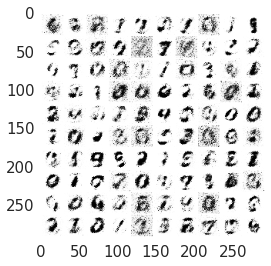

In [44]:
# u = np.random.standard_t(code_size-1, size=(batch_size, code_size))
u = np.random.normal(loc=0.0, scale=5.0, size=(batch_size, code_size))
I = grid2d(decoder([u])[0])
plt.imshow(I)

# Embedding

In [ ]:
from sklearn.manifold.t_sne import TSNE
tsne = TSNE(verbose=1)
x_code = encoder([X_train[:6000]])[0]
x_code, _ = embedding2d(x_code) # PCA to 2D

In [ ]:
_ = embedding2dplot(x_code, y_train[:6000])

# Citation

If you use this method in your research, please cite the original authors for their greate work:  
[Adversarial Autoencoders](http://arxiv.org/abs/1511.05644), Alireza Makhzani, Jonathon Shlens, Navdeep Jaitly, Ian Goodfellow.

If you are feeling charitable you can also refer your reader to this notebook on Github:  
https://github.com/EderSantana/seya/blob/master/examples/Adversarial\%20Autoencoder.ipynb
    
Paper with further work coming soon!